# Projeto de Aprendizado de Máquina: Classificador Musical

Marina Rocha Guimarães

Ygor Kupas

Temos dois objetivos centrais nesse notebook:

* No cenário I iremos utilizar um SVM e analisar os diferentes resultados obtidos ao utilizarmos diferentes extrações de features (LPC, MFCC e Mel Spectogram) e suas combinações (MFCC + LPC e Mel Spectogram + LPC). Isso é uma simplificação baseada no estudo realizado em [1];
    
* No cenário II iremos utilizar 3 SVMs, com o intuito de comparar os resultados obtidos no cenário I com o resultado obtido ao separar inicialmente os 4 estilos musicais em 2 grupos distintos (como feito em [2]).

[1] [Mutiara,A.B.; Refianti,R.; Mukarromah, N. R. A. Musical Genre Classification Using Support Vector Machines and Audio Features. Faculty of Computer Science and Information Technology, Gunadarma University. Setembro, 2016](https://pdfs.semanticscholar.org/92b4/66160755cd4c540cad6ab744019ee006e4ec.pdf)

[2] [XU, Changseng et al. Musical Genre Classification Using Support Vector Machines. Laboratories for Information Technology, 2003](https://www.researchgate.net/publication/4015150_Musical_genre_classification_using_support_vector_machines)


Indice<br/><br/>1 - [Importando Libs](#1---Importando-Libs)<br/>2 - [Apagando os avisos do notebook](#2---Apagando-os-avisos-do-notebook)<br/>3 - [Carregando Dataset](#3---Carregando-Dataset)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 - [Testando os audios](#3.1---Testando-os-audios)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 - [Separando Treinamento e Teste](#3.2---Separando-Treinamento-e-Teste)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 - [Verificando a distribuição de treinamento e teste entre os estilos musicais](#3.2.1---Verificando-a-distribuição-de-treinamento-e-teste-entre-os-estilos-musicais)<br/>4 - [Extração de Features](#4---Extração-de-Features)<br/>5 - [Cenário I](#5---Cenário-I)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1 - [Encontrando os melhores parâmetros para cada feature](#5.1---Encontrando-os-melhores-parâmetros-para-cada-feature)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2 - [Melhor Resultado](#5.2---Melhor-Resultado)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2.1 - [Tentativa de predição com o melhor modelo](#5.2.1---Tentativa-de-predição-com-o-melhor-modelo)<br/>6 - [Cenário II](#6---Cenário-II)6.1 - [Analisando cada extração de feature](#6.1---Analisando-cada-extração-de-feature)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6.2 - [Melhor Resultado](#6.2---Melhor-Resultado)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6.2.1 - [Tentativa de predição com o melhor modelo](#6.2.1---Tentativa-de-predição-com-o-melhor-modelo)<br/>7 - [Comparando os melhores resultados de cada cenário](#7---Comparando-os-melhores-resultados-de-cada-cenário)

# 1 - Importando Libs

In [1]:
# Libs matplotlib, numpy and pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Lib librosa
import librosa
import librosa.display

# Lib OS
from os import listdir
from os.path import isfile, join, exists

# Lib ipwidgets
from ipywidgets import interact, IntSlider, interact_manual
import ipywidgets as widgets

# Lib IPtyhon
from IPython import display as ipd

# Lib glob
import glob

# Lib sklearn
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix

# Lib keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers

# Lib collections
from collections import defaultdict

# 2 - Apagando os avisos do notebook

In [5]:
# Warnings off
import warnings
warnings.filterwarnings('ignore')

# 3 - Carregando Dataset

Baixar todo o [dataset](https://www.kaggle.com/carlthome/gtzan-genre-collection) (genre/) e colocar na mesma pasta do projeto.

In [6]:
def import_signal(path):
    
    # Test if path exists
    if( exists(path) == False ):
        print("Path does not exist, download from https://www.kaggle.com/carlthome/gtzan-genre-collection")
        return 0, 0
    
    # Load files woth glob
    files = glob.glob(path + '*.au')
    audios = []
    
    # Load audio files with sample rate 22050 Hz
    for file in files: 
        s, sr = librosa.core.load(file, sr=22050)
        audios.append(s)
        
    # Return audio vector and sample rate
    return audios, sr

Iremos considerar os seguintes rótulos para cada estilo:

    * Popular  =>  y=0 e y2=0
    * Clássico =>  y=1 e y2=0
    * Jazz     =>  y=2 e y2=1
    * Rock     =>  y=3 e y2=1
    
Isso porque **y** equivale ao rótulo do **primeiro cenário**, no qual temos apenas uma SVM e 4 possíveis saídas. Já o **segundo cenário** usa tanto o **y2** (na primeira SVM) como o **y** (já que a primeira SVM é usada para separar os estilos popular e clássico dos estilos jazz e rock).

In [8]:
# Get audios dataframe
def get_audios_df():
    
    cont = 0
    audios_dict = defaultdict(list)
    
    # Loop in music genres
    for musical_genre in ['pop', 'classical', 'jazz', 'rock']:

        # Importing signals
        audios, sr =  import_signal(f'genres/{musical_genre}/') # local
#         audios, sr =  import_signal(f'drive/MyDrive/machine_learning/genres/{musical_genre}/') # colab
        
        #
        audios_dict[musical_genre].append(audios)
        
        # Joining all genres in one dataframe
        audios_df_aux = pd.DataFrame([[x] for x in audios], columns=['x'])
        genre_dict_y = {'pop':0, 'classical':1, 'jazz':2, 'rock':3}
        genre_dict_y2 = {'pop':0, 'classical':0, 'jazz':1, 'rock':1}
        audios_df_aux['y'] = genre_dict_y[f'{musical_genre}']
        audios_df_aux['y2'] = genre_dict_y2[f'{musical_genre}']
        
        if cont == 0:
            audios_df = audios_df_aux
        else:
            audios_df = pd.concat([audios_df, audios_df_aux])
        cont+=1
        
    return audios_df, audios_dict, sr

In [5]:
# Uncomment it if you are using google colab

# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# Call "get_audio_df()" function
audios_df, audios_dict, sr = get_audios_df()

# Shuffle all music genres
audios_df = audios_df.sample(frac=1).reset_index(drop=True) # shuffle

# Printing rows number
print(f'Rows: {len(audios_df)}')
audios_df.head(2)

Rows: 400


,x,y,y2
0,"[-0.10235596, -0.06472778, -0.0051879883, 0.02...",3,1
1,"[0.07803345, -0.03765869, 0.12664795, 0.165618...",0,0


## 3.1 - Testando os audios

In [10]:
# Declaring global variables to interact
global chosed_musical_genre
chosed_musical_genre = 'pop'
global chosed_file
chosed_file = 0

In [21]:
# Dropdown from widgets
w_dropdown = widgets.Dropdown(options=['pop', 'classical', 'jazz', 'rock'],
                              value='pop', description='Genero:', disabled=False)

output_dropdown = widgets.Output()

# Changing "chosed_musical_genre"
def on_change_dropdown(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global chosed_musical_genre
        chosed_musical_genre = change['new']
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([17])'))

w_dropdown.observe(on_change_dropdown)
display(w_dropdown, output_dropdown)

Dropdown(description='Genero:', options=('pop', 'classical', 'jazz', 'rock'), value='pop')

Output()

<IPython.core.display.Javascript object>

In [22]:
# IntSlider from widgets
w_int_slider = widgets.IntSlider(value=0, min=0, max=99, step=1,
                                 description='File:', disabled=False,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='d')

output_int_slider = widgets.Output()

# Changing "chosed_file"
def on_change_int_slider(change):
    with output_int_slider:
        global chosed_file
        chosed_file = change['new']
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([17])'))

w_int_slider.observe(on_change_int_slider, 'value')
display(w_int_slider, output_int_slider)

IntSlider(value=0, continuous_update=False, description='File:', max=99)

Output()

In [23]:
# Show audio
ipd.Audio(audios_dict[chosed_musical_genre][0][chosed_file], rate=sr)

## 3.2 - Separando Treinamento e Teste

In [24]:
# Using numpy random to separate training and test data
# Could use sklearn.model_selection.train_test_split

# 80% for training and 20% for tests (approximately)
msk = np.random.rand(len(audios_df)) < 0.8
train = audios_df[msk]
test = audios_df[~msk]

# Showing train and test's rows
print(f'Rows train:{len(train)}')
print(f'Rows test:{len(test)}')

Rows train:318
Rows test:82


### 3.2.1 - Verificando a distribuição de treinamento e teste entre os estilos musicais

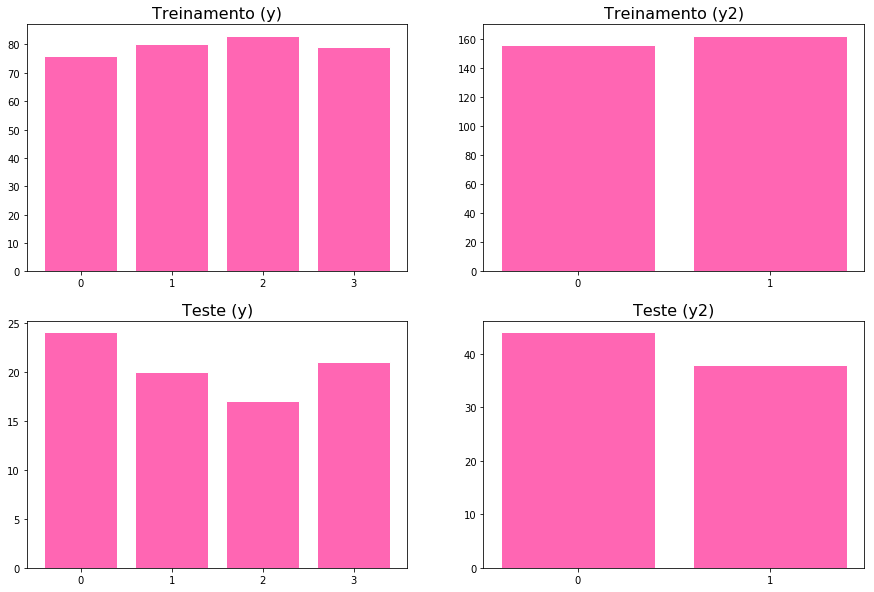

In [25]:
# Printing a histogram for test and train distribution

bins_y = np.sort(train['y'].unique())
bins_y2 = np.sort(train['y2'].unique())

fig, axs = plt.subplots(2, 2, figsize=(15,10))

axs[0, 0].bar(bins_y, np.histogram(train['y'], bins=len(bins_y))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[0, 0].set_xticks(bins_y)
axs[0, 0].set_title('Treinamento (y)', fontsize=16)

axs[0, 1].bar(bins_y2, np.histogram(train['y2'], bins=len(bins_y2))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[0, 1].set_xticks(bins_y2)
axs[0, 1].set_title('Treinamento (y2)', fontsize=16)

axs[1, 0].bar(bins_y, np.histogram(test['y'], bins=len(bins_y))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[1, 0].set_xticks(bins_y)
axs[1, 0].set_title('Teste (y)', fontsize=16)

axs[1, 1].bar(bins_y2, np.histogram(test['y2'], bins=len(bins_y2))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[1, 1].set_xticks(bins_y2)
axs[1, 1].set_title('Teste (y2)', fontsize=16)

plt.show()

# 4 - Extração de Features

In [12]:
def mfcc_feature_extract(x_column, sr):
    mfcc_list = []
    for x in x_column:
        
        # Transform to frequency domain with cossenoid transform
        # .flatten() to transform an array to a single vector
        mfcc_flatten = np.array(librosa.feature.mfcc(y=x, sr=sr)).flatten()
        
        # It is done becouse for each x, it has different sizes 
        # of MFCC (max is 26280)
        zeros = np.zeros((26280 - len(mfcc_flatten))) 
                       
        # Append in MFCC list
        mfcc_list.append(np.concatenate((mfcc_flatten, zeros), axis=0))
        
    return mfcc_list

def mel_spect_feature_extract(x_column, sr):
    mel_spect_list = []
    for x in x_column:
        
        # Transform to frequency domain
        # .flatten() to transform an array to a single vector
        mel_spect_flatten = np.array(librosa.feature.melspectrogram(y=x, sr=sr)).flatten()
        
        # It is done becouse for each x, it has different sizes 
        # of Mel Specs (max is 168192)
        zeros = np.zeros((168192 - len(mel_spect_flatten))) 
                              
        # Append in Mel_Spec list
        mel_spect_list.append(np.concatenate((mel_spect_flatten, zeros), axis=0))
        
    return mel_spect_list

def lpc_feature_extract(x_column, order=6):
    lpc_list = []
    for x in x_column:
        # Linear 
        lpc = librosa.lpc(x, order=order)
        lpc_list.append(lpc)
    return lpc_list

In [13]:
# Get all features extrations
def feature_extract(df, sr):
    
    # MFCC
    df['mfcc'] = mfcc_feature_extract(df['x'], sr)
    
    # LPC
    df['lpc'] = lpc_feature_extract(df['x'], order=6)
    
    # Mel Spectogram
    df['mel_spect'] = mel_spect_feature_extract(df['x'], sr)
    
    # MFCC + LPC
    df['mfcc_lpc'] = (
        df['mfcc'].apply(lambda x: x.tolist()) + 
        df['lpc'].apply(lambda x: x.tolist())
    )
    
    # Mel Spectogram + LPC
    df['mel_spect_lpc'] = (
        df['mel_spect'].apply(lambda x: x.tolist()) + 
        df['lpc'].apply(lambda x: x.tolist())
    )
    
    return df 

In [14]:
# Train extraction
train = feature_extract(train, sr)
train.head(2)

NameError: ignored

In [19]:
# Test extraction
test = feature_extract(test, sr)
test.head(2)

,x,y,y2,mfcc,lpc,mel_spect,mfcc_lpc,mel_spect_lpc
4,"[-0.016723633, 0.0024719238, -0.0020751953, 0....",0,0,"[-104.91389465332031, -112.64622497558594, -13...","[1.0, -0.6648677, -0.28419054, 0.19508892, 0.0...","[0.4853304922580719, 0.9742664098739624, 0.718...","[-104.91389465332031, -112.64622497558594, -13...","[0.4853304922580719, 0.9742664098739624, 0.718..."
7,"[0.2557068, 0.2401123, 0.27786255, 0.379364, 0...",0,0,"[-80.98080444335938, -73.17125701904297, -69.9...","[1.0, -0.5806832, -0.35023203, -0.09842629, 0....","[85.43531799316406, 43.56767272949219, 28.7440...","[-80.98080444335938, -73.17125701904297, -69.9...","[85.43531799316406, 43.56767272949219, 28.7440..."


# 5 - Cenário I

* Usando uma rede SVM de apenas uma cama para reconhecer os 4 tipos musicais

## 5.1 - Encontrando os melhores parâmetros para cada feature

In [44]:
parameters = {'kernel':('poly', 'rbf'), 'C':[1, 50], 'degree':[1, 10], 'gamma':[0.1, 2.5]}

svc = svm.SVC()
model = GridSearchCV(svc, parameters)

features_params_dict = defaultdict(dict)

features_without_abrev = {'mfcc':'MFCC', 'lpc':'LPC', 'mel_spect':'Mel Spectogram',
                          'mfcc_lpc': 'MFCC + LPC', 'mel_spect_lpc': 'Mel Spectogram + LPC'}

 Mel Spectogram:

Best parameters: {'C': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}
Train accuracy: 100.0%
Test accuracy:  77.5%




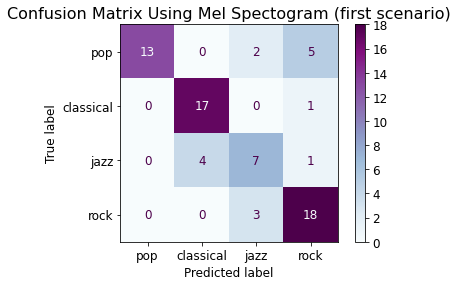

<Figure size 1440x1440 with 0 Axes>

In [45]:
for feature in ['mfcc', 'lpc', 'mel_spect', 'mfcc_lpc', 'mel_spect_lpc']:
        
    print(f'\033[1m {features_without_abrev[feature]}:\033[0;0m\n')
    
    # Training
    model.fit(train[f'{feature}'].to_list(), train['y'].to_list())
    
    # Best Parameters
    print(f'Best parameters: {model.best_params_}')
    features_params_dict[feature] = model.best_params_
    
    # Train and Test Score
    train_score = model.score(train[f'{feature}'].to_list(), train['y'].to_list())
    test_score = model.score(test[f'{feature}'].to_list(), test['y'].to_list())
    
    print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score))
    print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score))
    print('\n')
    
    plt.rcParams.update({'font.size': 12})
    disp = plot_confusion_matrix(model, test[f'{feature}'].to_list(), 
                                 test['y'].to_list(), labels=[0,1,2,3],
                                 display_labels=['pop', 'classical', 'jazz', 'rock'],
                                 cmap=plt.cm.BuPu)
    disp.ax_.set_title(f'Confusion Matrix Using {features_without_abrev[feature]} (first scenario)', 
                       fontsize=16)
    plt.figure(figsize=(20,20))
    plt.show()
    
    print('\n')

## 5.2 - Melhor Resultado

Analisando o melhor resultado com base principalmente na porcentagem de acerto no dataset de teste, temos 2 melhores modelos:
    * SVM com kernel=poly e extração de feature MFCC
    * SVM com kernel=poly e extração de feature MFCC+LPC

Nota-se que os dois resultados acima são identicos. Vamos então escolher o primeiro citado para verificar o resultado final.

In [18]:
# Training
model.fit(train['mfcc'].to_list(), train['y'].to_list())

# Train and Test Score
train_score = model.score(train['mfcc'].to_list(), train['y'].to_list())
test_score = model.score(test['mfcc'].to_list(), test['y'].to_list())

plt.rcParams.update({'font.size': 12})
disp = plot_confusion_matrix(model, test['mfcc'].to_list(), 
                             test['y'].to_list(), labels=[0,1,2,3],
                             display_labels=['pop', 'classical', 'jazz', 'rock'],
                             cmap=plt.cm.BuPu)
disp.ax_.set_title('Confusion Matrix Using MFCC (first scenario)', fontsize=16)
plt.figure(figsize=(20,20))
plt.show()

print('\n')
print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score))
print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score))
print('\n')

NameError: ignored

### 5.2.1 - Tentativa de predição com o melhor modelo

In [26]:
global chosed_musical_genre_scenario1
chosed_musical_genre_scenario1 = 'pop'

global chosed_file_scenario1
chosed_file_scenario1 = 0

In [27]:
w_dropdown = widgets.Dropdown(options=['pop', 'classical', 'jazz', 'rock'],
                              value='pop', description='Genero:', disabled=False)

output_dropdown = widgets.Output()

def on_change_dropdown(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global chosed_musical_genre_scenario1
        chosed_musical_genre_scenario1 = change['new']
        
w_dropdown.observe(on_change_dropdown)
display(w_dropdown, output_dropdown)

Dropdown(description='Genero:', options=('pop', 'classical', 'jazz', 'rock'), value='pop')

Output()

In [41]:
w_int_slider = widgets.IntSlider(value=0, min=0, max=99, step=1,
                                 description='File:', disabled=False,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='d')

output_int_slider = widgets.Output()

def on_change_int_slider(change):
    with output_int_slider:
        global chosed_file_scenario1
        chosed_file_scenario1 = change['new']
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([38])'))
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([39])'))
w_int_slider.observe(on_change_int_slider, 'value')
display(w_int_slider, output_int_slider)

IntSlider(value=0, continuous_update=False, description='File:', max=99)

Output()

In [43]:
ipd.Audio(audios_dict[chosed_musical_genre_scenario1][0][chosed_file_scenario1], rate=sr)

In [ ]:
audio_test = audios_dict[chosed_musical_genre_scenario1][0][chosed_file_scenario1]
audio_test_mfcc = mfcc_feature_extract([audio_test], sr)[0]

genre_dict = {0: 'popular', 1:'classico',
              2:'jazz', 3:'rock'}

predicted_musical_genre = genre_dict[model.predict([audio_test_mfcc])[0]]

print('\nA música inserida pertence ao estilo musical ' + '\033[1m' + f'{predicted_musical_genre}' + '\033[0;0m')

# 6 - Cenário II

* Usando 3 redes SVM:
    * SVM1 - separa os estilos pop e classico dos estilos jazz e rock
    * SVM2 - separa o estilo pop do estilo classico
    * SVM3 - separa o estilo jazz do estilo rock

In [23]:
def training_a_model(x, y, feature, features_params_dict):
    
    kernel = features_params_dict[f'{feature}']['kernel']
    degree = features_params_dict[f'{feature}']['degree']
    gamma = features_params_dict[f'{feature}']['gamma']
    C = features_params_dict[f'{feature}']['C']
    
    model = svm.SVC(kernel=kernel, degree=degree, gamma=gamma, C=C)
        
    model.fit(x, y)
    return model

In [24]:
def get_second_scenario_score_and_models(train, test, features_params_dict, 
                                         feature_ex_svm1='lpc', feature_ex_svm23='mfcc'):
    
    # SVM1
    model1 = training_a_model(train[f'{feature_ex_svm1}'].to_list(), 
                              train['y2'].to_list(),
                              feature_ex_svm1, features_params_dict)
    train['y2_predicted'] = model1.predict(train[f'{feature_ex_svm1}'].to_list())
    
    #SVM2
    train_0 = train[train['y2_predicted']==0]
    train_0 = train_0[train_0['y'].isin([0,1])]
    
    model2 = training_a_model(train_0[f'{feature_ex_svm23}'].to_list(), 
                              train_0['y'].to_list(),
                              feature_ex_svm23, features_params_dict)
    train_0['y_predicted'] = model2.predict(train_0[f'{feature_ex_svm23}'].to_list())
    test_0 = test[test['y2']==0]
    
    #SVM3
    train_1 = train[train['y2_predicted']==1]
    train_1 = train_1[train_1['y'].isin([2,3])]
    
    model3 = training_a_model(train_1[f'{feature_ex_svm23}'].to_list(), 
                              train_1['y'].to_list(),
                              feature_ex_svm23, features_params_dict)
    train_1['y_predicted'] = model3.predict(train_1[f'{feature_ex_svm23}'].to_list())
    test_1 = test[test['y2']==1]
    
    train_score = (
        model2.score(train_0[f'{feature_ex_svm23}'].to_list(), train_0['y'].to_list()) * 0.5 +
        model3.score(train_1[f'{feature_ex_svm23}'].to_list(), train_1['y'].to_list()) * 0.5
    )
    
    test_score = (
        model2.score(test_0[f'{feature_ex_svm23}'].to_list(), test_0['y'].to_list()) * 0.5 +
        model3.score(test_1[f'{feature_ex_svm23}'].to_list(), test_1['y'].to_list()) * 0.5
    )
    
    return model1, model2, model3, train_score, test_score

In [25]:
# Create own predict function
def second_scenario_predict_an_audio(feature1, feature2, model1, model2, model3):    
    y2_predicted = model1.predict(feature1)
    
    y_predicted_list = []
    i=0
    for predicted in y2_predicted:
        
        feature = feature2[i]
        
        if predicted == 0:
            y_predicted = model2.predict([feature])
        elif predicted == 1:
            y_predicted = model3.predict([feature])
            
        y_predicted_list.append(y_predicted)
        
        i+=1
    
    return y_predicted_list

## 6.1 - Analisando cada extração de feature

Aqui vamos analisar os resultados do cenário II alterando a extração de feature utilizada na SVM1 e nas SVM2 e SVM3 - vale ressaltar que a extração de feature utilizada na SVM2 é igual àquela utilizada na SVM3.

Por simplificação, vamos apenas analisar as extrações LPC e MFCC e vamos utilizar os melhores parâmetros já encontrados anteriormente.

In [26]:
for feature1 in ['mfcc', 'lpc']:
    for feature2 in ['mfcc', 'lpc']
    
        print(f'\033[1m {features_without_abrev[feature1]} & {features_without_abrev[feature2]}:\033[0;0m\n')

        model1, model2, model3, train_score, test_score = (
                get_second_scenario_score_and_models(train, test, features_params_dict, 
                                                     feature_ex_svm1=feature1, feature_ex_svm23=feature2)
        )

        print('Train accuracy: {:.1%}'.format(train_score))
        print('Test accuracy:  {:.1%}'.format(test_score))
        print('\n')

        predictions = (
            second_scenario_predict_an_audio(test[f'{feature1}'].to_list(), 
                                             test[f'{feature2}'].to_list(), 
                                             model1, model2, model3)
        )
        predictions = [x[0] for x in predictions]

        plt.rcParams.update({'font.size': 12})

        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test['y'].to_list(), predictions),
                                      display_labels=['pop', 'classical', 'jazz', 'rock'])
        disp = disp.plot(include_values=True,
                         cmap=plt.cm.BuPu)
        disp.ax_.set_title(f'Confusion Matrix Using {features_without_abrev[feature1]} & {features_without_abrev[feature2]} (second scenario)', 
                           fontsize=16)

        plt.figure(figsize=(20,20))
        plt.show()
        
        print('\n')

SyntaxError: ignored

## 6.2 - Melhor Resultado

Analisando o melhor resultado com base principalemente na porcentagem de acerto no dataset de teste, o melhor modelo foi o que utilizou kernel=poly e extração de feature MFCC nos 3 SVM utilizados.

In [ ]:
model1, model2, model3, train_score, test_score = (
    get_second_scenario_score_and_models(train, test, feature_ex_svm1='mfcc',
                                         feature_ex_svm23='mfcc', degree=2)
)

predictions = (
    second_scenario_predict_an_audio(test['mfcc'].to_list(), 
                                     test['mfcc'].to_list(), 
                                     model1, model2, model3)
)
predictions = [x[0] for x in predictions]

plt.rcParams.update({'font.size': 12})

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test['y'].to_list(), predictions),
                              display_labels=['pop', 'classical', 'jazz', 'rock'])
disp = disp.plot(include_values=True,
                 cmap=plt.cm.BuPu)
disp.ax_.set_title('Confusion Matrix Using MFCC & MFCC (second scenario)', fontsize=16)

plt.figure(figsize=(20,20))
plt.show()

print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score))
print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score))
print('\n')

### 6.2.1 - Tentativa de predição com o melhor modelo

In [ ]:
global chosed_musical_genre_scenario2
chosed_musical_genre_scenario2 = 'pop'

global chosed_file_scenario2
chosed_file_scenario2 = 0

In [28]:
w_dropdown = widgets.Dropdown(options=['pop', 'classical', 'jazz', 'rock'],
                              value='pop', description='Genero:', disabled=False)

output_dropdown = widgets.Output()

def on_change_dropdown(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global chosed_musical_genre_scenario2
        chosed_musical_genre_scenario2 = change['new']

w_dropdown.observe(on_change_dropdown)
display(w_dropdown, output_dropdown)

Dropdown(description='Genero:', options=('pop', 'classical', 'jazz', 'rock'), value='pop')

Output()

In [45]:
w_int_slider = widgets.IntSlider(value=0, min=0, max=99, step=1,
                                 description='File:', disabled=False,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='d')

output_int_slider = widgets.Output()

def on_change_int_slider(change):
    with output_int_slider:
        global chosed_file_scenario2
        chosed_file_scenario2 = change['new']
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([54])'))
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([55])'))

w_int_slider.observe(on_change_int_slider, 'value')
display(w_int_slider, output_int_slider)

IntSlider(value=0, continuous_update=False, description='File:', max=99)

Output()

In [48]:
ipd.Audio(audios_dict[chosed_musical_genre_scenario2][0][chosed_file_scenario2], rate=sr)

NameError: name 'chosed_musical_genre_scenario2' is not defined

In [ ]:
audio_test = audios_dict[chosed_musical_genre_scenario2][0][chosed_file_scenario2]
audio_test_mfcc = mfcc_feature_extract([audio_test], sr)[0]

genre_dict = {0: 'popular', 1:'classico',
              2:'jazz', 3:'rock'}

predicted_musical_genre = (
    genre_dict[
        second_scenario_predict_an_audio([audio_test_mfcc], [audio_test_mfcc], model1, model2, model3)[0][0]
    ]
)

print('\nA música inserida pertence ao estilo musical ' + '\033[1m' + f'{predicted_musical_genre}' + '\033[0;0m')

# 7 - Comparando os melhores resultados de cada cenário

In [32]:
# Cenário I
model, train_score1, test_score1 = (
    get_first_scenario_score_and_model(train, test, feature_ex='mfcc', 
                                       return_model=True, degree=2)
)

plt.rcParams.update({'font.size': 12})
disp = plot_confusion_matrix(model, test['mfcc'].to_list(), 
                             test['y'].to_list(), labels=[0,1,2,3],
                             display_labels=['pop', 'classical', 'jazz', 'rock'],
                             cmap=plt.cm.BuPu)
disp.ax_.set_title('Confusion Matrix Using MFCC (first scenario)', fontsize=16)
plt.figure(figsize=(20,20))
plt.show()

print('\n')
print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score1))
print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score1))
print('\n')

# Cenário II
model1, model2, model3, train_score2, test_score2 = (
    get_second_scenario_score_and_models(train, test, feature_ex_svm1='mfcc',
                                         feature_ex_svm23='mfcc', degree=2)
)

predictions = (
    second_scenario_predict_an_audio(test['mfcc'].to_list(), 
                                     test['mfcc'].to_list(), 
                                     model1, model2, model3)
)
predictions = [x[0] for x in predictions]

plt.rcParams.update({'font.size': 12})

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test['y'].to_list(), predictions),
                              display_labels=['pop', 'classical', 'jazz', 'rock'])
disp = disp.plot(include_values=True,
                 cmap=plt.cm.BuPu)
disp.ax_.set_title('Confusion Matrix Using MFCC & MFCC (second scenario)', fontsize=16)

plt.figure(figsize=(20,20))
plt.show()

print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score2))
print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score2))
print('\n')

NameError: ignored

Nota-se que, ao utilizar a separação inicial dos 4 estilos musicais em 2 grupos (cenário 2) a eficácia do modelo melhorou. Isso nos mostra que, tendo as mesmas ferramentas, podemos melhorar nosso modelo se conhecermos mais sobre o dataset utilizado - nesse caso, ao conhecer um pouco sobre teoria da música, percebemos que seria mais fácil separar, por exemplo, o estilo popular do estilo clássico do que o estilo jazz do estilo classico.